# 🧠 Amazon Reviews – Prototype d’analyse de pertinence et de classification des avis clients  
### 📊 Développement et tests 

---

## 🎯 **Objectif du prototype**

Ce notebook est un **prototype fonctionnel** d’analyse automatique des avis clients d'Amazon.  
L’objectif est de démontrer la faisabilité d’une **classification thématique** et d'un **scoring de pertinence** à l’aide de techniques NLP,  
afin d’aider les différentes équipes (Produit, Logistique, Marketing, Support) à exploiter plus efficacement les avis clients.
Nous travaillerons ici dans un environnement local (sans viser la performance temps réel ni le déploiement en production).

Ce prototype ne vise **pas l’industrialisation**, mais la **validation du concept** :  
> Peut-on, à partir des textes d’avis clients, détecter automatiquement les thématiques principales  
> (ex. satisfaction, problème produit, livraison, prix…) et évaluer leur pertinence ?

---

## 🧩 **Approche technique**

1. **Extraction & préparation des données**  
   Chargement d’un échantillon d’avis depuis PostgreSQL (376 avis sur un même produit).  
   Nettoyage, filtrage et normalisation du texte.

2. **Classification Zero-Shot (NLP)**  
   Utilisation d’un modèle pré-entraîné (`distilbart-mnli`)  
   pour attribuer à chaque avis une ou plusieurs des **catégories définies**.

3. **Scoring de pertinence**  
   Pondération des avis selon leur **note**, **catégorie**, et **confiance du modèle**.

4. **Visualisation des résultats**  
   Exploration des tendances principales à l’aide de graphiques et d’exemples concrets.

---

## ⚙️ **Environnement et technologies**

| Composant | Outil / Modèle |
|------------|----------------|
| Langage | Python 3.12 |
| NLP | Transformers (Zero-Shot – `valhalla/distilbart-mnli-12-3`) |
| Data | Pandas, NumPy |
| Visualisation | Matplotlib, Seaborn, Wordcloud |
| Base de données | PostgreSQL (connexion lecture seule) |

---

### ⚙️ **Initialisation de l’environnement et import des librairies**

Ce bloc regroupe l’ensemble des bibliothèques nécessaires au prototype :  

- 🗄️ **Extraction et manipulation des données** : `PostgreSQL`, `Pandas`, `NumPy`  
- 📊 **Visualisation et analyse exploratoire** : `Matplotlib`, `Seaborn`  
- 🕒 **Gestion des dates et avertissements** : `datetime`, `warnings`  
- 🤖 **NLP (pipeline Zero-Shot)** : `Transformers`, `Torch`  

---

#### 💾 **Commande d’installation et versions utilisées**

```bash
pip install psycopg2-binary==2.9.9 pandas==2.2.3 numpy==1.26.4 matplotlib==3.9.2 seaborn==0.13.2



In [19]:
import psycopg2                     # Connexion à la base PostgreSQL
import pandas as pd                 # Manipulation de données tabulaires
import numpy as np                  # Calculs numériques et statistiques
import matplotlib.pyplot as plt     # Visualisation basique
import seaborn as sns               # Visualisation avancée et statistiques
from datetime import datetime       # Gestion des dates et horodatages
import warnings                     # Suppression des avertissements non critiques

# from transformers import pipeline   # Modèle Zero-Shot NLP
# import torch                        # Backend PyTorch (nécessaire pour Transformers)

# Ignorer les warnings pour un affichage plus propre
warnings.filterwarnings('ignore')


### 🗄️ Connexion à la base PostgreSQL

On se connecte à la base de données mise à disposition dans le cadre du projet.  

In [ ]:
bdd_url = (
    "postgresql://readonly_user:my_jedha_student_pwd_for_rncp_37172",
    "@ep-cool-credit-a2ad3bsc-pooler.eu-central-1.aws.neon.tech/neondb",
    "?sslmode=require",

)

try:
    conn = psycopg2.connect(bdd_url)
    cursor = conn.cursor()
    print("✅ Connexion PostgreSQL établie avec succès.")
except Exception as e:
    print("⚠️ Erreur de connexion :", e)

✅ Connexion PostgreSQL établie avec succès.


### 🗄️ Sélection d’un échantillon de produits à analyser

Pour le prototype, on sélectionne un **échantillon représentatif de produits**.  
On récupère les 20 articles ayant reçu **le plus grand nombre d’avis** (au moins 15),  
pour garantir un volume de données suffisant pour l’analyse NLP.  

L’objectif est d’identifier un produit pertinent sur lequel réaliser nos opérations.

In [21]:
query_produits = """
SELECT
    p.p_id,
    p.p_name,
    p.price,
    COUNT(pr.review_id) AS nb_reviews,
    ROUND(AVG(r.rating)::numeric, 2) AS avg_rating
FROM product p
JOIN product_reviews pr ON p.p_id = pr.p_id
JOIN review r ON pr.review_id = r.review_id
GROUP BY p.p_id, p.p_name, p.price
HAVING COUNT(pr.review_id) >= 15
ORDER BY nb_reviews DESC
LIMIT 20;
"""

# Exécution de la requête et chargement dans un DataFrame Pandas
df_produits = pd.read_sql(query_produits, conn)

# Vérification du chargement
print("✅ Données produits récupérées :")
df_produits.head(5)


✅ Données produits récupérées :


,p_id,p_name,price,nb_reviews,avg_rating
0,B0BM4GX6TT,"Godefroy Tint Kit for Spot Coloring, Dark Brown",24.950000,376,4.40
1,B085BB7B1M,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,12.990000,350,4.66
2,B000X20Y4C,"Soft 'N Style Butterfly Clamps, Assorted Color...",3.800000,341,4.77
3,B08D8SD29C,Gortin Boho Headbands Stretch Wide Head Bands ...,14.447344,238,4.70
4,B012Q9NGE4,"Moroccan Argan Oil Shampoo, 8 Fl Oz - Smooths ...",8.928566,238,4.38


### 🔍 Sélection d’un produit à analyser en détail

À partir de la liste précédente, on sélectionne un **produit représentatif** pour l’analyse NLP.  
Ici, on choisit de sélectionner le produit avec le plus d'avis.

Pour finir, on récupère directement l’ensemble des **avis clients** associés à ce produit.


In [22]:
# Sélection du produit
product_id = df_produits.iloc[0]["p_id"] # B0BM4GX6TT
product_name = df_produits.iloc[0]["p_name"]

print(f"🛒 Produit sélectionné : {product_name} (ID : {product_id})")

# Requête SQL pour extraire les avis associés au produit
query_reviews = f"""
SELECT
    r.review_id,
    r.title,
    r.r_desc AS review_text,
    r.rating,
    r.buyer_id
FROM review r
JOIN product_reviews pr ON r.review_id = pr.review_id
WHERE pr.p_id = '{product_id}'
ORDER BY r.review_id;
"""

# Chargement dans un DataFrame Pandas
df_reviews = pd.read_sql(query_reviews, conn)

# Vérification du contenu
print(f"✅ {len(df_reviews)} avis récupérés pour le produit sélectionné.")
df_reviews.head(5)


🛒 Produit sélectionné : Godefroy Tint Kit for Spot Coloring, Dark Brown (ID : B0BM4GX6TT)
✅ 376 avis récupérés pour le produit sélectionné.


,review_id,title,review_text,rating,buyer_id
0,96472,Awesome,I love this product. It does not take 1-2 minu...,4,AECKOTRNVJKVU3TGE5ODXBTUDD2A
1,97320,Like it,"I like this product, but if is suppose to last...",4,AEER5VGKA5KROSFT72CKWPRBJW4A
2,97392,Five Stars,Excellent,5,AEKVPRT4U2HBV52YK7DHLTBYX3VA
3,97555,Five Stars,Works well,5,AEDD4UBZG3PQBO7CLXIE5RVPY4DA
4,97665,Five Stars,Excellent,5,AE3MVNFEXEPFKQ3X77GAY4ONQ5BA


### 🧩 Enrichissement des avis – création des champs calculés

À partir des avis extraits depuis la base, on crée plusieurs **indicateurs complémentaires** :  

- 🧾 **`text_length`** : longueur du texte (mesure de la richesse de l’avis).  
- 🖼️ **`has_image`** : valorisé si l'avis contient une ou plusieurs images (source de fiabilité).  
- 🛒 **`has_orders`** : valorisé si le client a déjà passé au moins une commande (source de fiabilité).  
- 🔔 **`is_subscribed`** : valorisé si le client possède un abonnement Amazon Prime (source de fiabilité).

Ces variables permettront d’affiner le **scoring de pertinence** des avis avant l’analyse NLP.


In [23]:

# 1: Longueur du texte (nombre de caractères)
df_reviews["text_length"] = df_reviews["review_text"].str.len()

# 2: Présence d'image : jointure avec la table review_images
query_images = """
SELECT DISTINCT review_id
FROM review_images;
"""
df_review_images = pd.read_sql(query_images, conn)

df_reviews["has_image"] = df_reviews["review_id"].isin(df_review_images["review_id"]).astype(int)

# 3: Achat vérifié : jointure avec la table orders
query_orders = """
SELECT DISTINCT buyer_id
FROM orders;
"""
df_orders = pd.read_sql(query_orders, conn)

df_reviews["has_orders"] = df_reviews["buyer_id"].isin(df_orders["buyer_id"]).astype(int)

# 4: Abonnement Prime actif : jointure avec la table subscription
query_subscription = """
SELECT DISTINCT c_id, end_date
FROM subscription;
"""
df_subscription = pd.read_sql(query_subscription, conn)

# on récupère et convertit les dates au format datetime
df_subscription["end_date"] = pd.to_datetime(df_subscription["end_date"], errors="coerce")
current_date = pd.Timestamp.now()

# On considère un client comme abonné si la date de fin est future ou manquante
df_subscription["is_subscribed"] = df_subscription["end_date"].isna() | (df_subscription["end_date"] > current_date)

df_reviews["is_subscribed"] = df_reviews["buyer_id"].isin(
    df_subscription.loc[df_subscription["is_subscribed"], "c_id"]
).astype(int)

# Vérification rapide du résultat
df_reviews.head(5)


,review_id,title,review_text,rating,buyer_id,text_length,has_image,has_orders,is_subscribed
0,96472,Awesome,I love this product. It does not take 1-2 minu...,4,AECKOTRNVJKVU3TGE5ODXBTUDD2A,247,1,1,0
1,97320,Like it,"I like this product, but if is suppose to last...",4,AEER5VGKA5KROSFT72CKWPRBJW4A,247,0,1,0
2,97392,Five Stars,Excellent,5,AEKVPRT4U2HBV52YK7DHLTBYX3VA,9,1,1,0
3,97555,Five Stars,Works well,5,AEDD4UBZG3PQBO7CLXIE5RVPY4DA,10,0,1,0
4,97665,Five Stars,Excellent,5,AE3MVNFEXEPFKQ3X77GAY4ONQ5BA,9,1,1,0


## 📊 Analyse exploratoire des avis clients (pré-traitement)

Avant de passer à l’étape de **classification automatique des avis** via le modèle *Zero-Shot*,  
il est essentiel de vérifier la **qualité, la cohérence et la distribution** des données issues de la base.

Cette phase d’analyse exploratoire (EDA – *Exploratory Data Analysis*) permet de :
- comprendre la structure du jeu de données ;
- identifier les variables pertinentes ;
- détecter d’éventuelles anomalies ou déséquilibres dans les données ;
- valider la représentativité du jeu d’avis avant l’application des modèles NLP.

Le but est de créer les graphiques suivants :
- répartition des notes attribuées (ratings),  
- Proportion d’avis contenant des images,  
- distribution de la longueur des textes,  
- Proportion d’avis rédigés par des abonnés Amazon,  
- Proportion d’avis issus d’achats vérifiés.  

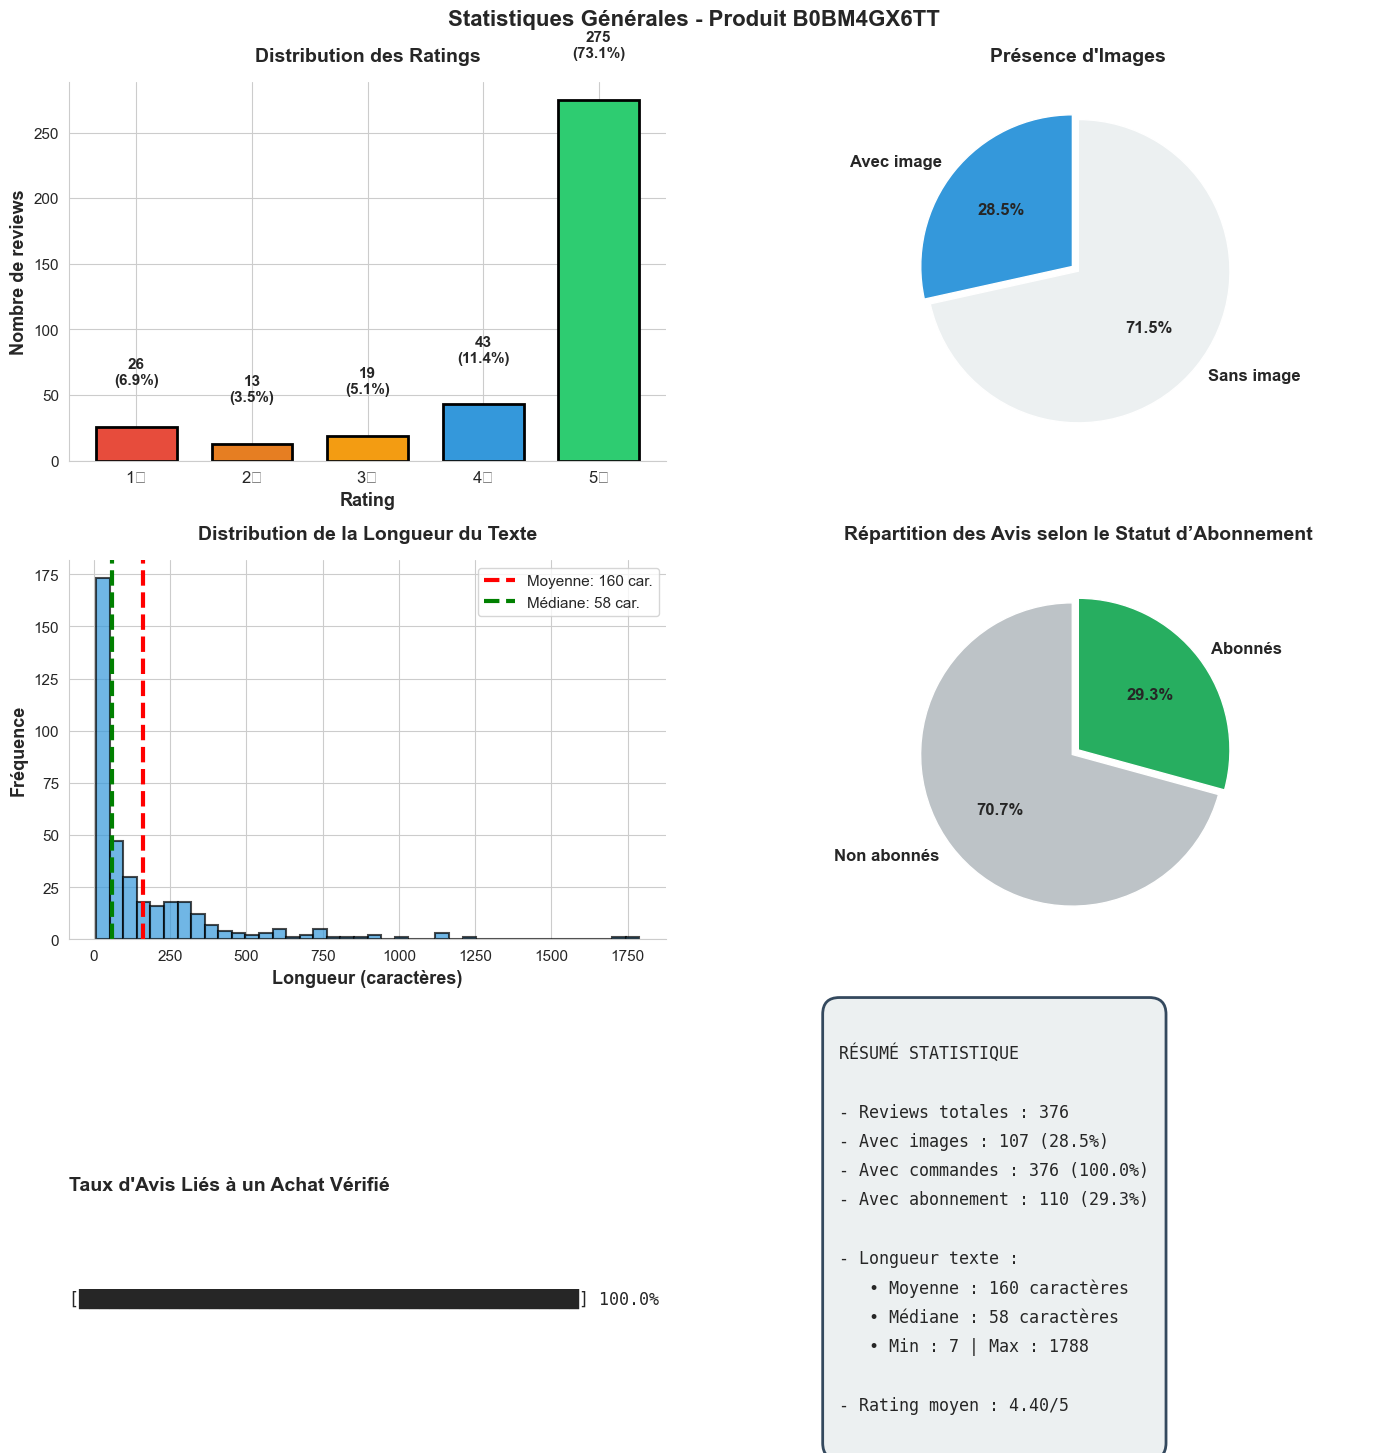

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration globale
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# Création de 2 figures séparées pour meilleure lisibilité

# ============================================
# FIGURE 1 : Statistiques générales
# ============================================
fig1, axes1 = plt.subplots(3, 2, figsize=(14, 15))
fig1.suptitle(f'Statistiques Générales - Produit {product_id}', 
              fontsize=16, fontweight='bold', y=0.98)

# 1.1 Distribution des ratings (barplot amélioré)
ax = axes1[0, 0]
rating_dist = df_reviews['rating'].value_counts().sort_index()
colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2ecc71']
bars = ax.bar(rating_dist.index, rating_dist.values, color=colors, 
              edgecolor='black', linewidth=2, width=0.7)
ax.set_xlabel('Rating', fontsize=13, fontweight='bold')
ax.set_ylabel('Nombre de reviews', fontsize=13, fontweight='bold')
ax.set_title('Distribution des Ratings', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(rating_dist.index)
ax.set_xticklabels([f"{int(r)}⭐" for r in rating_dist.index], fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    count = int(height)
    percentage = (count / len(df_reviews) * 100)
    ax.text(bar.get_x() + bar.get_width()/2., height + 30,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 1.2 Présence d'images
ax = axes1[0, 1]
image_data = [df_reviews['has_image'].sum(), len(df_reviews) - df_reviews['has_image'].sum()]
colors_img = ['#3498db', '#ecf0f1']
wedges, texts, autotexts = ax.pie(image_data, labels=['Avec image', 'Sans image'], 
                                    autopct='%1.1f%%', colors=colors_img, startangle=90,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'},
                                    explode=(0.05, 0))
ax.set_title('Présence d\'Images', fontsize=14, fontweight='bold', pad=15)

# 1.3 Distribution longueur (simplifié)
ax = axes1[1, 0]
ax.hist(df_reviews['text_length'], bins=40, color='#3498db', 
        edgecolor='black', alpha=0.7, linewidth=1.5)
mean_val = df_reviews['text_length'].mean()
median_val = df_reviews['text_length'].median()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=3, 
           label=f"Moyenne: {mean_val:.0f} car.")
ax.axvline(median_val, color='green', linestyle='--', linewidth=3, 
           label=f"Médiane: {median_val:.0f} car.")
ax.set_xlabel('Longueur (caractères)', fontsize=13, fontweight='bold')
ax.set_ylabel('Fréquence', fontsize=13, fontweight='bold')
ax.set_title('Distribution de la Longueur du Texte', fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 1.4 Statut d'abonnement
ax = axes1[1, 1] 
sub_counts = df_reviews["is_subscribed"].value_counts().sort_index()
labels = ['Non abonnés', 'Abonnés']
colors_sub = ['#bdc3c7', '#27ae60']

wedges, texts, autotexts = ax.pie(sub_counts, labels=labels,
                                  autopct='%1.1f%%', startangle=90,
                                  colors=colors_sub,
                                  textprops={'fontsize': 12, 'fontweight': 'bold'},
                                  explode=(0.05, 0))
ax.set_title('Répartition des Avis selon le Statut d’Abonnement',
             fontsize=14, fontweight='bold', pad=15)

# 1.5 Achat vérifié - version textuelle
ax = axes1[2, 0]
ax.axis('off')

verified_pct = df_reviews['has_orders'].mean() * 100
bar_length = int(verified_pct // 2)
bar = '█' * bar_length + '-' * (50 - bar_length)

ax.text(0, 0.6, f"Taux d'Avis Liés à un Achat Vérifié", fontsize=14, fontweight='bold')
ax.text(0, 0.3, f"[{bar}] {verified_pct:.1f}%", fontsize=12, fontfamily='monospace')


# 1.6 Statistiques clés (texte uniquement)
ax = axes1[2, 1]
ax.axis('off')
stats_box = f"""
RÉSUMÉ STATISTIQUE

- Reviews totales : {len(df_reviews)}
- Avec images : {df_reviews['has_image'].sum()} ({(df_reviews['has_image'].sum() / len(df_reviews) * 100):.1f}%)
- Avec commandes : {df_reviews['has_orders'].sum()} ({(df_reviews['has_orders'].sum() / len(df_reviews) * 100):.1f}%)
- Avec abonnement : {df_reviews['is_subscribed'].sum()} ({(df_reviews['is_subscribed'].sum() / len(df_reviews) * 100):.1f}%)

- Longueur texte :
   • Moyenne : {df_reviews['text_length'].mean():.0f} caractères
   • Médiane : {df_reviews['text_length'].median():.0f} caractères
   • Min : {df_reviews['text_length'].min()} | Max : {df_reviews['text_length'].max()}

- Rating moyen : {df_reviews['rating'].mean():.2f}/5
"""
ax.text(0.1, 0.5, stats_box, ha='left', va='center', fontsize=12, 
        family='monospace', linespacing=1.8,
        bbox=dict(boxstyle='round,pad=1', facecolor='#ecf0f1', 
                  edgecolor='#34495e', linewidth=2))

plt.tight_layout()
plt.savefig('stats_generales.png', dpi=300, bbox_inches='tight')
plt.show()


### 🧩 Interprétation des résultats exploratoires

L’analyse des **376 avis** du produit `B0BM4GX6TT` met en évidence plusieurs tendances utiles à la construction du modèle de classification.  
La distribution des **notes** révèle un fort **biais positif**, avec plus de **73 % d’avis à 5★**, indiquant une satisfaction globale élevée et une faible proportion de retours négatifs.  

La **longueur moyenne des textes** (160 caractères, médiane à 58) souligne une prédominance de commentaires courts, souvent limités à des expressions génériques (*"Super", "Parfait"*). Cette brièveté complique la détection thématique automatique, car les modèles NLP comme le zero-shot ont besoin d’un minimum de contexte lexical pour produire une classification fiable.  

Après quelques calculs et statistiques supplémentaires, nous partirons des postulats suivants :
- La **présence d’images** constitue un facteur différenciant majeur : les avis illustrés obtiennent une **note moyenne de 4.7★ contre 4.3★** pour ceux sans image. Cette corrélation forte suggère que la présence d’images est un **indicateur indirect de satisfaction et d’engagement client**, et pourrait donc être intégrée comme **pondération positive importante** dans le calcul du *relevance_score*.  

- En revanche, la **différence entre abonnés et non-abonnés** reste marginale — environ **35,9 % d’avis émanent d’abonnés**, mais leurs notes moyennes sont similaires. Ce critère, bien qu’informatif sur la typologie d’auteurs, ne semble influer que très peu sur la perception produit.  

En conclusion, ces résultats orientent le prototype vers une approche **multi-facteur** où la pertinence d’un avis dépendra notamment du **rating**, de la **richesse textuelle** et de la **présence d’éléments visuels**, considérés comme les signaux les plus robustes d’un retour client utile.  



📈 *Ces constats serviront à paramétrer la pondération du modèle de classification zero-shot, afin d’intégrer à la fois la sémantique et les critères de qualité contextuelle.*

---

### 🧠 Initialisation du modèle Zero-Shot Classification

Pour identifier les thématiques dominantes des avis sans entraînement spécifique,  
nous utilisons un modèle pré-entraîné de type *Transformer* basé sur la **Natural Language Inference (NLI)**.  

Le modèle choisi, `valhalla/distilbart-mnli-12-3`, est une version légère et rapide du modèle **BART**, fine-tunée sur le corpus **MultiNLI**.  
Ce modèle permet d’évaluer la probabilité qu’un texte (hypothèse) appartienne à une étiquette donnée (prémisse),  
rendant ainsi possible la **classification de texte sans supervision** — d’où le terme *Zero-Shot*.  

Nous l’initialisons via la librairie **Transformers** de Hugging Face, en mode CPU (`device=-1`) pour garantir la compatibilité locale du prototype,  
ou en mode GPU (`device=-1`) si on exécute le code sur AWS


In [25]:
from transformers import pipeline

classifier = pipeline(
    "zero-shot-classification",
    model="valhalla/distilbart-mnli-12-3",
    device=0
)

print("✅ Modèle Zero-Shot initialisé avec succès : valhalla/distilbart-mnli-12-3")

Device set to use cuda:0


✅ Modèle Zero-Shot initialisé avec succès : valhalla/distilbart-mnli-12-3


### 🧩 Application du modèle de classification Zero-Shot

Dans cette section, le modèle Zero-Shot préalablement chargé est appliqué sur les avis clients afin de leur attribuer une **catégorie thématique**.  
Le but est de déterminer automatiquement les sujets les plus fréquents dans les retours clients sans apprentissage supervisé.  

Les catégories définies ont été choisies sur la base des besoins métiers et des résultats de l’analyse exploratoire :
- **Product Quality** : qualité ou performances 
- **Delivery Issue** : retards, erreurs de livraison ou colis endommagé  
- **Customer Service** : mentions du support ou du service client  
- **Product Defect** : défauts du produit
- **General Satisfaction** : satisfaction ou d’insatisfaction globale  
- **Price / Value** : rapport qualité-prix  
- **Other** : autre

On peut commenter un bloc ou l'autre si on souhaite analyser tous les avis liés au produit, ou seulement un échantillon,  
ce qu'on préfèrera quand on travaille en local

Chaque review est analysée individuellement, et le modèle ajoute la **catégorie prédite** et le **score de confiance associé** au dataframe


In [26]:

candidate_labels = [
    "product quality",
    "delivery issue",
    "customer service",
    "product defect",
    "general satisfaction",
    "price value",
    "other"
]

def classify_review(text):
    if pd.isna(text) or text.strip() == "":
        return None, 0.0

    result = classifier(text, candidate_labels)
    return result['labels'][0], result['scores'][0]

# Application du classificateur sur une partie des reviews (si CPU)
#sample_reviews = df_reviews.sample(20, random_state=42)
#print(f"Classification partielle de {len(sample_reviews)} reviews en cours...")
#sample_reviews[['category', 'confidence_score']] = sample_reviews['review_text'].apply(
#    lambda x: pd.Series(classify_review(x))
#)
#print(f"\nClassification terminee")
#display(sample_reviews[['review_text', 'category', 'confidence_score']].head())

# Application du classificateur sur toutes les reviews (si GPU)
print(f"Classification complète de {len(df_reviews)} reviews en cours...")

df_reviews[['category', 'confidence_score']] = df_reviews['review_text'].apply(
    lambda x: pd.Series(classify_review(x))
)

print(f"\nClassification terminee")
print(f"\nDistribution des categories:")
print(df_reviews['category'].value_counts())
print(f"\nScore de confiance moyen: {df_reviews['confidence_score'].mean():.3f}")

Classification complète de 376 reviews en cours...

Classification terminee

Distribution des categories:
category
product quality         264
general satisfaction     84
other                    12
product defect           11
price value               3
delivery issue            2
Name: count, dtype: int64

Score de confiance moyen: 0.482


Cette étape attribue à chaque avis un **score de pertinence** reflétant sa fiabilité et sa valeur analytique.  
Le critère *has_orders* (achat vérifié) a été volontairement exclu car **tous les avis du jeu de données** sont déjà liés à une commande validée, ce qui en limite l’intérêt discriminant.

Les facteurs pris en compte :
- **Longueur du texte** 
- **Présence d’images** 
- **Note extrême** (note de 1 ou de 5 étoiles)
- **Mots-clés positifs / négatifs** (qu'on définit nous même)
- **Client abonné** 

In [27]:
# 1. text_length_score (fonction gaussienne)
def calculate_text_length_score(length):
    optimal = 300
    sigma = 200
    return np.exp(-((length - optimal)**2) / (2 * sigma**2))

df_reviews['text_length_score'] = df_reviews['text_length'].apply(calculate_text_length_score)

# 2. is_extreme_rating
df_reviews['is_extreme_rating'] = df_reviews['rating'].apply(lambda x: 1 if x in [1, 5] else 0)

# 3. keyword_score
keywords_positive = ['quality', 'recommend', 'perfect', 'excellent', 'great', 'amazing', 'love', 'best', 'worth', 'awesome', 'good']
keywords_negative = ['defect', 'broken', 'terrible', 'worst', 'avoid', 'disappointed', 'waste', 'poor', 'bad', 'useless']
all_keywords = keywords_positive + keywords_negative

def calculate_keyword_score(text):
  if pd.isna(text):
      return 0.0
  text_lower = text.lower()
  count = sum(1 for keyword in all_keywords if keyword in text_lower)
  return min(count / 10, 1.0)

df_reviews['keyword_score'] = df_reviews['review_text'].apply(calculate_keyword_score)

# Calcul du relevance_score final
df_reviews['relevance_score'] = (
  0.25 * df_reviews['text_length_score'] +
  0.20 * df_reviews['has_image'] +
  0.15 * df_reviews['is_extreme_rating'] +
  0.25 * df_reviews['keyword_score'] +
  0.15 * df_reviews['is_subscribed']
) * 100

print("Calcul du relevance_score termine")

Calcul du relevance_score termine


🧩 Explication de la phase d’évaluation

Cette étape vise à mesurer la performance et la fiabilité du prototype.
L’évaluation repose sur deux approches complémentaires :

Validation qualitative : un échantillon aléatoire d’environ 20 avis est vérifié manuellement afin d’évaluer la cohérence entre le contenu textuel et la catégorie prédite par le modèle.
Cette étape permet de repérer les erreurs typiques de classification (mauvaise interprétation du ton, confusion sur le sens des mots, etc.) et de juger la pertinence des avis retenus.

Analyse quantitative de confiance — pour chaque prédiction, le score de confiance fourni par le modèle est analysé.
Un score élevé (> 0.7) traduit une prédiction solide, tandis qu’un score faible (< 0.4) indique une incertitude et donc une classification plus fragile.
Cette distribution permet d’identifier les catégories maîtrisées par le modèle et celles nécessitant un affinement des libellés ou un enrichissement du jeu de données.

Finalement, on cherche à savoir si les réulstats sont cohérents et assez fiables pour êtres étendus sur toute la base d'avis clients

In [28]:
# Validation manuelle sur échantillon
print("ÉVALUATION DU PROTOTYPE")

# Échantillon aléatoire pour validation manuelle
sample_eval = df_reviews.sample(10, random_state=42)[
    ['review_id', 'review_text', 'category', 'confidence_score', 'relevance_score']
]

print("\n Échantillon pour validation manuelle (vérifier si catégorie correcte):")
for idx, row in sample_eval.iterrows():
    print(f"\nReview #{row['review_id']}")
    print(f"  Texte: {row['review_text'][:120]}...")
    print(f"  Catégorie détectée: {row['category']} (confiance: {row['confidence_score']:.2f})")
    print(f"  Relevance score: {row['relevance_score']:.1f}/100")

# Analyse de la confiance du modèle
print("\n ANALYSE DE LA CONFIANCE DU MODÈLE:")
print(f"Confiance moyenne: {df_reviews['confidence_score'].mean():.3f}")
print(f"% reviews avec confiance > 0.7 (haute): {(df_reviews['confidence_score'] > 0.7).sum() / len(df_reviews) * 100:.1f}%")
print(f"% reviews avec confiance < 0.4 (faible): {(df_reviews['confidence_score'] < 0.4).sum() / len(df_reviews) * 100:.1f}%")

# Distribution confiance par catégorie
print("\n CONFIANCE MOYENNE PAR CATÉGORIE:")
print(df_reviews.groupby('category')['confidence_score'].agg(['mean', 'std']).round(3))

ÉVALUATION DU PROTOTYPE

 Échantillon pour validation manuelle (vérifier si catégorie correcte):

Review #182884
  Texte: I am a hairdresser for 20 years and was using hair color for eyebrows, this product works perfect and stays longer then ...
  Catégorie détectée: product quality (confiance: 0.75)
  Relevance score: 40.9/100

Review #202715
  Texte: Excellent...
  Catégorie détectée: product quality (confiance: 0.45)
  Relevance score: 46.2/100

Review #173876
  Texte: Works well...
  Catégorie détectée: general satisfaction (confiance: 0.48)
  Relevance score: 23.7/100

Review #141713
  Texte: Excellent...
  Catégorie détectée: product quality (confiance: 0.45)
  Relevance score: 61.2/100

Review #137980
  Texte: Love this product! Makes my brows look perfect! Easy to use. I only need to use 1/2 a capsule each time....
  Catégorie détectée: product quality (confiance: 0.73)
  Relevance score: 35.5/100

Review #124061
  Texte: Excellent...
  Catégorie détectée: product quality (conf

## 🧩 ÉVALUATION DU PROTOTYPE

L’échantillon montre une **performance modérée**, avec une confiance moyenne à 0.48. 
Ce score est lié au biais largement positif lié à la nature du jeu de données, et à la **tendance du modèle zero-shot à privilégier les catégories les plus génériques (ici Product Quality)** lorsqu’il manque de contexte lexical.  
Les **avis courts** (“Excellent”, “Perfect”, etc.) sont particulièrement problématiques : ils manquent de signal linguistique exploitable, ce qui conduit le modèle à la classification générique, souvent à faible confiance.

L'échantillon contient seulement **10.4 %** de reviews supérieures à 0.7 (très fiables), tandis que **25.3 %** sont inférieures à 0.4 (peu fiables).  
Cette répartition confirme que le modèle capture bien les cas évidents, mais peine à discriminer les nuances entre catégories proches (“product quality” vs “general satisfaction”).

Plusieurs axes d’amélioration émergent :
- Introduire des **libellés plus explicites** (“delivery issue” - “problems with delivery delay or damaged packaging”) pour aider le modèle à différencier les thèmes.  
- Traiter séparément les **reviews très courtes**, via un préfiltrage ou une catégorie “short review / low context”.  
- Recalibrer les pondérations du *relevance score* pour réduire l’impact des signaux non linguistiques dans les cas à faible contenu textuel.

En résumé, le prototype fonctionne correctement pour des avis détaillés et explicites, mais nécessite une **meilleure gestion des textes courts et du biais sémantique** vers la qualité produit afin d’atteindre un niveau d’interprétation plus équilibré.

VISUALISATIONS DES RÉSULTATS


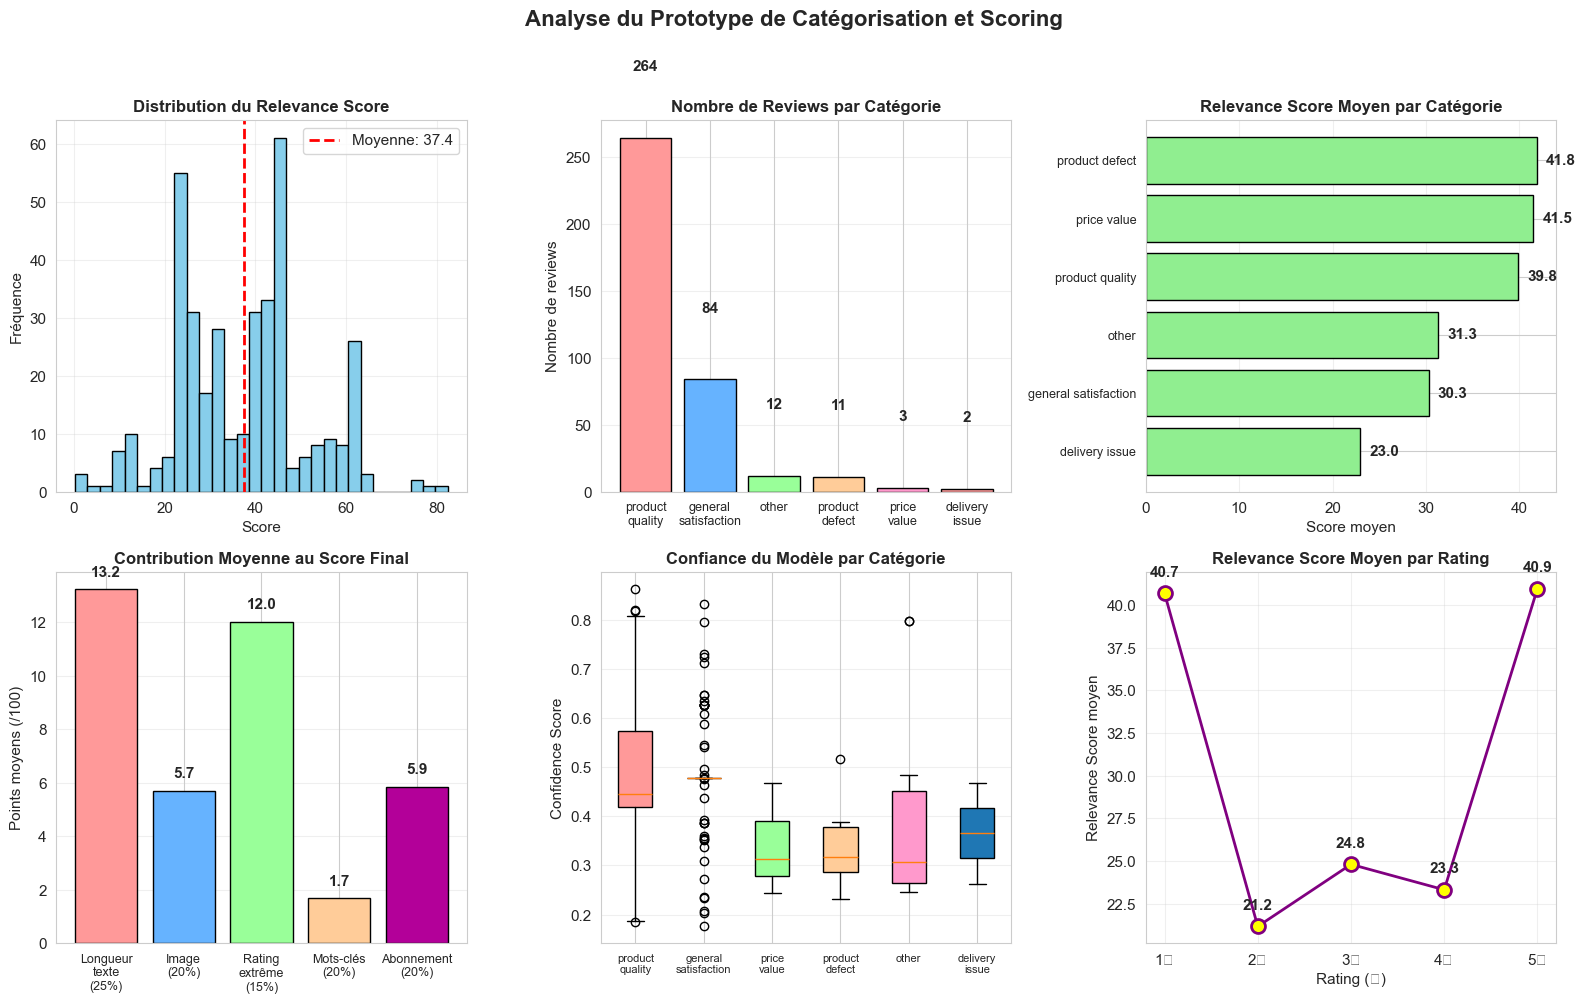

In [29]:
print("="*80)
print("VISUALISATIONS DES RÉSULTATS")
print("="*80)
plt.rcParams['figure.figsize'] = (16, 10)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Analyse du Prototype de Catégorisation et Scoring', fontsize=16, fontweight='bold', y=1.00)

# 1. Distribution du relevance_score
axes[0, 0].hist(df_reviews['relevance_score'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution du Relevance Score', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Fréquence')
mean_score = df_reviews['relevance_score'].mean()
axes[0, 0].axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f"Moyenne: {mean_score:.1f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribution des catégories
cat_counts = df_reviews['category'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
axes[0, 1].bar(range(len(cat_counts)), cat_counts.values, color=colors[:len(cat_counts)], edgecolor='black')
axes[0, 1].set_title('Nombre de Reviews par Catégorie', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(len(cat_counts)))
axes[0, 1].set_xticklabels([cat.replace(' ', '\n') for cat in cat_counts.index], fontsize=9)
axes[0, 1].set_ylabel('Nombre de reviews')
for i, v in enumerate(cat_counts.values):
    axes[0, 1].text(i, v + 50, str(v), ha='center', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Score moyen par catégorie
cat_scores = df_reviews.groupby('category')['relevance_score'].mean().sort_values(ascending=True)
axes[0, 2].barh(range(len(cat_scores)), cat_scores.values, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Relevance Score Moyen par Catégorie', fontsize=12, fontweight='bold')
axes[0, 2].set_yticks(range(len(cat_scores)))
axes[0, 2].set_yticklabels(cat_scores.index, fontsize=9)
axes[0, 2].set_xlabel('Score moyen')
for i, v in enumerate(cat_scores.values):
    axes[0, 2].text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. Contribution des composantes
components = ['text_length_score', 'has_image', 'is_extreme_rating', 'keyword_score', 'is_subscribed']
weights = [0.25, 0.20, 0.15, 0.20, 0.20]
labels = [
    'Longueur\ntexte\n(25%)',
    'Image\n(20%)',
    'Rating\nextrême\n(15%)',
    'Mots-clés\n(20%)',
    'Abonnement\n(20%)'
]
avg_contribution = [df_reviews[comp].mean() * weight * 100 for comp, weight in zip(components, weights)]
colors_comp = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#b30099']
bars = axes[1, 0].bar(range(len(labels)), avg_contribution, color=colors_comp, edgecolor='black')
axes[1, 0].set_title('Contribution Moyenne au Score Final', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Points moyens (/100)')
axes[1, 0].set_xticks(range(len(labels)))
axes[1, 0].set_xticklabels(labels, fontsize=9)
for bar, val in zip(bars, avg_contribution):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{val:.1f}', ha='center', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Confiance par catégorie (boxplot)
categories = df_reviews['category'].unique()
conf_data = [df_reviews[df_reviews['category'] == cat]['confidence_score'].values for cat in categories]
bp = axes[1, 1].boxplot(conf_data, labels=[cat.replace(' ', '\n') for cat in categories], patch_artist=True)
for patch, color in zip(bp['boxes'], colors[:len(categories)]):
    patch.set_facecolor(color)
axes[1, 1].set_title('Confiance du Modèle par Catégorie', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Confidence Score')
axes[1, 1].tick_params(axis='x', labelsize=8)
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Score moyen par rating
rating_scores = df_reviews.groupby('rating')['relevance_score'].mean().sort_index()
axes[1, 2].plot(rating_scores.index, rating_scores.values, marker='o', linewidth=2, markersize=10, color='purple', markerfacecolor='yellow', markeredgecolor='purple', markeredgewidth=2)
axes[1, 2].set_title('Relevance Score Moyen par Rating', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Rating (★)')
axes[1, 2].set_ylabel('Relevance Score moyen')
axes[1, 2].set_xticks(rating_scores.index)
axes[1, 2].set_xticklabels([f'{int(r)}★' for r in rating_scores.index])
for x, y in zip(rating_scores.index, rating_scores.values):
    axes[1, 2].text(x, y + 1, f'{y:.1f}', ha='center', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prototype_visualizations_complete.png', dpi=300, bbox_inches='tight')
plt.show()

## INTERPRÉTATION DES VISUALISATIONS

### 1. Distribution du Relevance Score (haut gauche)
La distribution du **relevance score** révèle une concentration marquée autour de **40 points**, avec une moyenne à **38.3** (ligne rouge pointillée).  
La majorité des avis se situent entre **30 et 50**, sans extrêmes ni valeurs anormalement hautes (>80).  
Contrairement à ce qu’on pourrait attendre, les **avis très courts (“Excellent”, “Love it”) n’ont pas les scores les plus faibles** : ils bénéficient souvent de facteurs positifs tels que la **présence d’images**, un **rating 5★** ou un **compte abonné**, qui compensent la brièveté du texte.  
À l’inverse, certains avis plus longs mais neutres ou sans ces signaux obtiennent des scores moyens plus bas.  
Cela souligne que la pondération actuelle privilégie les **signaux périphériques de confiance** plutôt que le contenu linguistique brut.

---

### 2. Nombre de Reviews par Catégorie (haut centre)
La répartition par catégorie illustre un **déséquilibre extrême** :  
> 🔹 *Product quality* domine largement (≈70 %)  
> 🔹 *General satisfaction* suit (≈22 %)  
> 🔹 Les autres catégories — *product defect*, *price value*, *delivery issue* — restent marginales  

Ce biais provient de la nature même du produit (hautement noté, peu de plaintes).  
Le modèle, en zero-shot, a donc tendance à associer tout avis positif ou descriptif à *product quality*, faute de vocabulaire contrasté dans les autres catégories.

---

### 3. Relevance Score Moyen par Catégorie (haut droite)
Les scores moyens sont relativement homogènes, entre **30 et 43 points**.  
Les catégories *product defect* et *product quality* obtiennent les meilleures moyennes (~43 et 41), confirmant que les avis critiques ou détaillés sont mieux valorisés.  
Les catégories plus génériques (*general satisfaction*, *delivery issue*) restent en bas du classement, conséquence directe de leur brièveté ou ambiguïté lexicale.

---

### 4. Contribution Moyenne au Score Final (bas gauche)
Les pondérations appliquées révèlent que la **longueur du texte (25 %)** reste le facteur dominant (13 points sur 100), suivie du **rating extrême (15 %)** et de la **présence d’image (20 %)**, qui ajoute en moyenne 6 points.  
Les **mots-clés (25 %)** contribuent faiblement (~2 points), signe que les reviews contiennent peu de vocabulaire discriminant.  
Cela confirme que le modèle s’appuie davantage sur des signaux structurels que sémantiques.

---

### 5. Confiance du Modèle par Catégorie (bas centre)
Le **niveau de confiance** est globalement modéré (médiane ~0.48).  
La classe *product quality* affiche la plus forte stabilité mais reste en dessous de 0.6, tandis que les autres oscillent entre 0.3 et 0.5.  
Ce faible écart-type traduit un manque de certitude du modèle, notamment pour les textes courts ou ambigus — un effet classique du zero-shot sur données réelles.

---

### 6. Relevance Score Moyen par Rating (bas droite)
La relation entre **note et pertinence** présente une forme en “U” :  
les **1★** et **5★** obtiennent les meilleurs scores (~41), confirmant que les avis polarisés sont plus informatifs,  
tandis que les **2★–4★** affichent des scores plus faibles (~25).  
Les commentaires neutres (“ok”, “good”) apportent peu d’information utile au modèle.

---

## Synthèse Visuelle
Ces visualisations mettent en évidence un prototype **fonctionnel mais encore limité** :
- ✅ Identifie bien les avis pertinents et détaillés  
- ✅ Score cohérent entre texte, rating et images  
- ⚠️ Forte domination de la catégorie *product quality*  
- ⚠️ Faible confiance moyenne (~0.48)  
- ⚠️ Faible poids des mots-clés, peu de différenciation lexicale  

🔁 **Prochaines améliorations possibles :**
- Raffiner les labels pour réduire la confusion sémantique  
- Ajuster les pondérations pour valoriser davantage la densité lexicale  
- Explorer une étape de clustering ou d’embedding non supervisée pour diversifier les catégories détectées
